In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lof import LOF
%matplotlib inline
from sklearn.cluster import KMeans

#### Пример генерации данных

Сгенерируем данные, красные точки - выбросы.

- $k$ - количество соседей LOF
- $m$ - количество выбросов

In [2]:
def generate_data(n, m):
    np.random.seed(42)
    data = np.concatenate((np.random.normal(0.6, 0.6, (n, 1)), np.random.normal(0.4, 0.2, (n, 1))), axis = 1) 
    blowouts = np.random.normal(0.5, 1.5, (m, 2))
    x = np.concatenate((data,blowouts))
    indx = np.arange(x.shape[0])
    return data, blowouts, x, indx

In [3]:
data, blowouts, x, indx = generate_data(n = 40, m = 5)

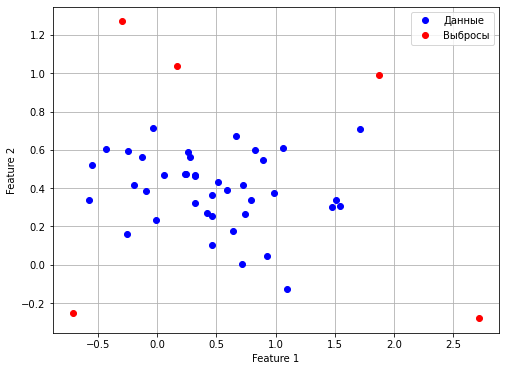

In [4]:
fig, ax = plt.subplots(1,1,figsize = (8,6))

ax.plot(data[:, 0], data[:, 1], 'bo', label = 'Данные')
ax.plot(blowouts[:, 0], blowouts[:, 1],'ro' ,label = 'Выбросы')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.legend()
ax.grid()
plt.show()

#### 1. Идентицикация выбросов по LOF

Найдём выбросы с заданным порогом

In [5]:
def blowouts_indx(dictionary, qntl = 0.75):
    vals = np.fromiter(dictionary.values(), dtype = float)
    qntl_vll = np.quantile(vals, qntl)
    result = np.array([point[0] for point in dictionary.items() if point[1] >= qntl_vll])
    return result

def metrics(y_pred, y_true, n, m):
    TP = 0 #правильно обнаруженные аномалии
    FP = 0 #ошибочно необнаруженные аномалии
    TN = 0 #ошибочно обнаруженные аномалии - ошибка второго рода
    FN = 0 #истинно отрицательные решения - правильно обнаруженные нормальные объекты
    for element in y_pred:
        if element in y_true:
            TP += 1
        else:
            FP += 1   
    TN = n - FP
    FN = m - TP
    accuracy = (TP + TN) / (TP + FP + FN + TN)
    error = 1 - accuracy
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    specifity = TN / (TN + FP)
    f_mera = 2 * (precision * recall) / (precision + recall)
    return accuracy, error, precision, recall, specifity, f_mera

def results(n = 40 , m = 5, k = 5, qntl = 0.95):
    data, blowouts, x, indx = generate_data(n, m)
    model = LOF(x, k)
    dest = model.compute_destinies()
    blow_pred = blowouts_indx(dest, qntl = 0.95)
    blow_true = np.arange(n, n + m)
    # print(f"Предсказанные выбросы: {blow_pred} \nПравильные выбросы: {blow_true}")
    results = np.array(metrics(blow_pred, blow_true, n, m))
    return results, blow_pred, blow_true

def full_results(ways):
    full_metrics = [dict(zip(z, results(**i))) for i, z in zip(list(ways.values()),\
                                                               [['metrics','pred_indx','true_indx']]*len(ways))]
    return full_metrics

##### Input

1. Для различных $k = 5, 7, 10$ при фиксированном $m$
2. Для различных $m = 5, 10, 15$ при фиксированном $k = 5$
3. Вычислить для каждого вариант метрики:

$$Accuracy = \frac{TP + TN}{TP + FP + FN + TN}$$

$$Error = 1 - accuracy$$

$$Precision = \frac{TP}{TP + FP}$$

$$Recall = \frac{TP}{TP + FN}$$

$$Specifity = \frac{TN}{TN + FP}$$

$$F = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$$

In [6]:
ways = {
    '1. fix m = 5: k = 5': {'n': 50, 'm': 5, 'k': 5},
    '1. fix m = 7: k = 7': {'n': 40, 'm': 5, 'k': 7},
    '1. fix m = 10: k = 10': {'n': 30, 'm' : 5, 'k': 10},
    '2. fix k = 5: m = 5': {'n' : 40, 'm' : 5, 'k' : 5},
    '2. fix k = 5: m = 10': {'n' : 40, 'm' : 10, 'k' : 5},
    '2. fix k = 5: m = 15': {'n' : 40, 'm' : 15, 'k' : 5},
}

#### Results

In [7]:
my_results = full_results(ways)
my_metrics = np.array([my_results[i]['metrics'] for i in range(len(my_results))])
my_pred_indx = [my_results[i]['pred_indx'] for i in range(len(my_results))]
my_true_indx = [my_results[i]['true_indx'] for i in range(len(my_results))]
my_columns = ['accuracy', 'error', 'precision', 'recall', 'specifity', 'F-мера']

final_result = pd.DataFrame(data = my_metrics.reshape(len(ways),len(my_columns)) , \
             columns = my_columns, index = ways.keys())
final_result['pred_indx'] = my_pred_indx
final_result['true_indx'] = my_true_indx

In [8]:
final_result

,accuracy,error,precision,recall,specifity,F-мера,pred_indx,true_indx
1. fix m = 5: k = 5,0.927273,0.072727,0.666667,0.4,0.98,0.500000,"[24, 51, 53]","[50, 51, 52, 53, 54]"
1. fix m = 7: k = 7,0.955556,0.044444,1.000000,0.6,1.00,0.750000,"[41, 42, 43]","[40, 41, 42, 43, 44]"
1. fix m = 10: k = 10,0.914286,0.085714,1.000000,0.4,1.00,0.571429,"[31, 32]","[30, 31, 32, 33, 34]"
2. fix k = 5: m = 5,0.955556,0.044444,1.000000,0.6,1.00,0.750000,"[41, 42, 43]","[40, 41, 42, 43, 44]"
2. fix k = 5: m = 10,0.860000,0.140000,1.000000,0.3,1.00,0.461538,"[41, 43, 47]","[40, 41, 42, 43, 44, 45, 46, 47, 48, 49]"
2. fix k = 5: m = 15,0.781818,0.218182,1.000000,0.2,1.00,0.333333,"[41, 47, 53]","[40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 5..."


#### Кластерный анализ k-means, k = 3

In [9]:
from sklearn import datasets

def euclidian_distance(x, y):
        return np.sqrt(np.sum((x - y) ** 2))

def blow_kmeans(X, kmeans, n_clusters = 3):
    centers = kmeans.cluster_centers_
    labels = kmeans.labels_
    clustered_data = [X[list(np.argwhere(labels == i).ravel())] for i in range(n_clusters)]
    blow = np.array([clustered_data[i]\
                         [np.argmax(np.array(list(map(lambda x: euclidian_distance(x, centers[i]), clustered_data[i]))))] \
                         for i in range(n_clusters)])
    return blow

In [10]:
iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target

kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
blow = blow_kmeans(X, kmeans, n_clusters = 3)
center = kmeans.cluster_centers_

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

#### 1. Визуализация в пространстве двух переменных (Sepal.Length, Sepal.Width)

#### 2. Выбросы с помощью кластерного анализа  

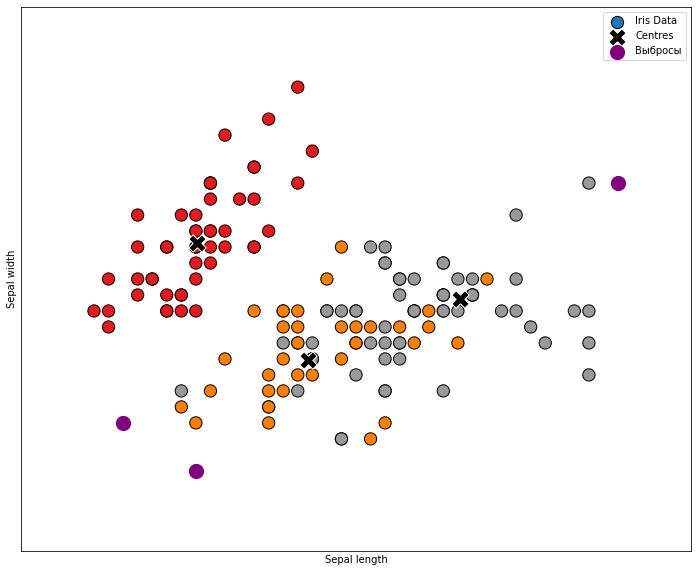

In [11]:
plt.figure(2, figsize=(12, 10))
plt.clf()

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor='k',label = 'Iris Data', s = 150)
plt.scatter(center[:, 0], center[:, 1], cmap=plt.cm.Set1, s =300, marker = 'X', \
            edgecolors='w', color = 'black', label = 'Centres')
plt.scatter(blow[:, 0], blow[:, 1], cmap=plt.cm.Set1, color = 'purple', label = 'Выбросы', s = 200)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend()
plt.xticks(())
plt.yticks(())
plt.show()